In [5]:
%load_ext autoreload
%autoreload 2
%pylab inline
import pandas as pd
import os

Populating the interactive namespace from numpy and matplotlib


# Dataframes
command: disjoint speaker split

In [6]:
dataframe_dir = '/home/muncok/DL/dataset/SV_sets/dataframes/'
data_dir = '/home/muncok/DL/dataset/SV_sets/speech_commands/'
command_df = pd.read_pickle(os.path.join(dataframe_dir,'Command_Dataframe.pkl'))

In [7]:
import honk_sv.train as hk
from honk_sv import model as mod

# SI Train

In [8]:
#TODO: correct splits
all_spks = command_df.spk.unique()
all_sents = command_df.sent.unique()
uttrs_counts = command_df.spk.value_counts()
sv_spks = list(uttrs_counts[:10].index)  # top 5 speakers whose number of recored uttrs is high
si_df = command_df[~command_df.spk.isin(sv_spks)]
si_spks = list(si_df.spk.unique())
sv_df = command_df[command_df.spk.isin(sv_spks)]

In [10]:
import random 

# command dataset is disjoint along speakers.
si_spk_train = si_df[si_df.set == 'train']
si_spk_val = si_df[si_df.set == 'val']
si_spk_test = si_df[si_df.set == 'test']
print("[spk] train:{}, val:{}, test:{}".format(len(si_spk_train), len(si_spk_val), len(si_spk_test)))

# spliting along the sents
random.shuffle(all_sents)
train_sent = [sent for sent in all_sents if sent not in ['yes', 'no', 'up', 'down']]
# train_sent = all_sents[:20]
val_sent = ['yes', 'no']
test_sent = ['up', 'down']
si_sent_train = si_df[si_df.sent.isin(train_sent)]
si_sent_val = si_df[si_df.sent.isin(val_sent)]
si_sent_test = si_df[si_df.sent.isin(test_sent)]
print("[sent] train:{}, val:{}, test:{}".format(len(si_sent_train), len(si_sent_val), len(si_sent_test)))

# random sampling
si_random_train = si_df.sample(frac=0.8)
si_random_test = si_df.drop(index=si_random_train.index)
si_random_val = si_random_test.sample(frac=0.5)
si_random_test = si_random_test.drop(index=si_random_val.index) 
print("[random] train:{}, val:{}, test:{}".format(len(si_random_train), len(si_random_val), len(si_random_test)))

[spk] train:50034, val:6563, test:6718
[sent] train:54087, val:4621, test:4607
[random] train:50652, val:6332, test:6331


In [11]:
import csv
import random

tags = ['train', 'val', 'test']
# choose a si split
sets = {'train':si_sent_train, 'val':si_sent_val, 'test':si_sent_test}
manifest_dir = "manifests/commands/"

for tag in tags:
    samples = []
    save_path = os.path.join(manifest_dir,'si_{}_{}_manifest.csv'.format("command", tag))
    with open(save_path, 'w') as f:
        for index, row in sets[tag].iterrows():
            file_path = os.path.join(data_dir, row.sent, row.file)
            label = row.label
            sample = ','.join([file_path, str(label)])
            samples.append(sample)
        random.shuffle(samples)
        writer = csv.writer(f, delimiter='\n', quoting=csv.QUOTE_NONE)
        writer.writerow(samples)
        print("{} was written".format(save_path))

manifests/commands/si_command_train_manifest.csv was written
manifests/commands/si_command_val_manifest.csv was written
manifests/commands/si_command_test_manifest.csv was written


In [10]:
model = "cnn-trad-pool2"
dataset = "command"

global_config = dict(model=model, dataset=dataset,
                     no_cuda=False,  gpu_no=0, 
                     n_epochs=30, batch_size=32,
                     lr=[0.001], schedule=[np.inf], dev_every=1, seed=0, use_nesterov=False,
                     cache_size=32768, momentum=0.9, weight_decay=0.00001, 
                     num_workers=16, print_step=100,
                     bn_size = 256)

builder = hk.ConfigBuilder(
                mod.find_config(model),
                mod.SpeechDataset.default_config(dataset),
                global_config)
parser = builder.build_argparse()
si_config = builder.config_from_argparse(parser)
si_config['model_class'] = mod.find_model(model)
hk.set_seed(si_config)

In [11]:
si_config['n_labels'] = 2000
manifest_dir = "manifests/commands/"
for tag in ['train', 'val', 'test']:
    si_config['{}_manifest'.format(tag)] =  os.path.join(manifest_dir,'si_{}_{}_manifest.csv'.format("command", tag))

si_model = si_config['model_class'](si_config)
si_config['input_file'] = ""
si_config['output_file'] = "models/si_command_sent_model.pt"

In [15]:
hk.train(si_config, model=si_model)

train step #99 accuracy: 0.0, loss: 7.600447177886963
train step #199 accuracy: 0.03125, loss: 7.530921459197998
train step #299 accuracy: 0.0, loss: 7.6306962966918945
train step #399 accuracy: 0.0, loss: 7.523818492889404
train step #499 accuracy: 0.0, loss: 7.254469871520996
train step #599 accuracy: 0.0, loss: 7.3958353996276855
train step #699 accuracy: 0.0, loss: 7.342167854309082
train step #799 accuracy: 0.0, loss: 7.548906326293945
train step #899 accuracy: 0.0, loss: 7.299840450286865
train step #999 accuracy: 0.0, loss: 7.408726692199707
train step #1099 accuracy: 0.0, loss: 7.220892906188965
train step #1199 accuracy: 0.03125, loss: 6.6673583984375
train step #1299 accuracy: 0.0, loss: 6.971616744995117
train step #1399 accuracy: 0.0, loss: 6.702081680297852
train step #1499 accuracy: 0.09375, loss: 5.906209468841553
train step #1599 accuracy: 0.09375, loss: 5.475890159606934
epoch #0, final dev accuracy: 0.09169429708222812
saving best model...
train step #1699 accuracy: 0

train step #12999 accuracy: 1.0, loss: 0.09425175189971924
train step #13099 accuracy: 0.75, loss: 0.6378297805786133
train step #13199 accuracy: 0.90625, loss: 0.40471285581588745
train step #13299 accuracy: 0.9375, loss: 0.3509768843650818
train step #13399 accuracy: 0.90625, loss: 0.4805479049682617
train step #13499 accuracy: 1.0, loss: 0.07186180353164673
epoch #7, final dev accuracy: 0.8459217506631299
train step #13599 accuracy: 0.9375, loss: 0.2253258228302002
train step #13699 accuracy: 0.96875, loss: 0.09566187858581543
train step #13799 accuracy: 0.90625, loss: 0.29490864276885986
train step #13899 accuracy: 0.9375, loss: 0.28347671031951904
train step #13999 accuracy: 1.0, loss: 0.026368260383605957
train step #14099 accuracy: 0.9375, loss: 0.10776811838150024
train step #14199 accuracy: 0.90625, loss: 0.24658793210983276
train step #14299 accuracy: 0.9375, loss: 0.35253405570983887
train step #14399 accuracy: 1.0, loss: 0.035034775733947754
train step #14499 accuracy: 0.87

train step #25599 accuracy: 0.90625, loss: 0.31973159313201904
train step #25699 accuracy: 0.96875, loss: 0.1758924126625061
train step #25799 accuracy: 0.96875, loss: 0.03388369083404541
train step #25899 accuracy: 1.0, loss: 0.042285799980163574
train step #25999 accuracy: 0.9375, loss: 0.0951489806175232
train step #26099 accuracy: 0.96875, loss: 0.09498530626296997
train step #26199 accuracy: 0.96875, loss: 0.051043152809143066
train step #26299 accuracy: 1.0, loss: 0.013870179653167725
train step #26399 accuracy: 1.0, loss: 0.024150550365447998
train step #26499 accuracy: 1.0, loss: 0.04104745388031006
train step #26599 accuracy: 1.0, loss: 0.03278738260269165
train step #26699 accuracy: 0.96875, loss: 0.329200804233551
train step #26799 accuracy: 0.9375, loss: 0.08144646883010864
train step #26899 accuracy: 0.96875, loss: 0.05406981706619263
train step #26999 accuracy: 1.0, loss: 0.05112171173095703
epoch #15, final dev accuracy: 0.8886107427055702
saving best model...
train step

train step #38399 accuracy: 1.0, loss: 0.01969003677368164
train step #38499 accuracy: 1.0, loss: 0.014749228954315186
train step #38599 accuracy: 0.96875, loss: 0.08541321754455566
train step #38699 accuracy: 1.0, loss: 0.014046907424926758
train step #38799 accuracy: 0.96875, loss: 0.17265987396240234
epoch #22, final dev accuracy: 0.8793269230769231
train step #38899 accuracy: 0.9375, loss: 0.22293716669082642
train step #38999 accuracy: 1.0, loss: 0.009490609169006348
train step #39099 accuracy: 0.96875, loss: 0.052754223346710205
train step #39199 accuracy: 0.96875, loss: 0.05191737413406372
train step #39299 accuracy: 1.0, loss: 0.0021694302558898926
train step #39399 accuracy: 0.9375, loss: 0.47890669107437134
train step #39499 accuracy: 1.0, loss: 0.015449702739715576
train step #39599 accuracy: 1.0, loss: 0.0024347305297851562
train step #39699 accuracy: 0.96875, loss: 0.10220706462860107
train step #39799 accuracy: 0.96875, loss: 0.058633625507354736
train step #39899 accurac

In [ ]:
# lstm model
model = "lstm"
dataset = "command"

global_config = dict(model=model, dataset=dataset,
                     no_cuda=False,  gpu_no=0, 
                     n_epochs=30, batch_size=16,
                     lr=[1e-05], schedule=[np.inf], dev_every=1, seed=0, use_nesterov=False,
                     cache_size=32768, momentum=0.9, weight_decay=0.00001, 
                     num_workers=16, print_step=100,)

builder = hk.ConfigBuilder(
                mod.find_config(model),
                mod.SpeechDataset.default_config(dataset),
                global_config)
parser = builder.build_argparse()
si_config = builder.config_from_argparse(parser)
si_config['model_class'] = mod.find_model(model)
hk.set_seed(si_config)

In [35]:
si_config['n_labels'] = 2000
si_config['h_dim'] = 500
si_config['n_layers'] = 1

manifest_dir = "manifests/commands/"
for tag in ['train', 'val', 'test']:
    si_config['{}_manifest'.format(tag)] =  os.path.join(manifest_dir,'si_{}_{}_manifest.csv'.format("command", tag))

si_lstm_model = si_config['model_class'](si_config)
si_config['input_file'] = ""
si_config['output_file'] = "models/si_command_lstm_model.pt"

In [ ]:
hk.train(si_config, model=si_lstm_model)

***

In [ ]:
si_model.load("models/si_command_random_model.pt")

# KWS Train

In [24]:
main_sents = ["Yes", "No", "Up", "Down", "Left",
             "Right", "On", "Off", "Stop", "Go", "Zero", "One", "Two", "Three", "Four",
             "Five", "Six", "Seven", "Eight", "Nine"] 
main_sents = list(map(lambda x: x.lower(), main_sents))
sent_labels = list(main_sents)

In [25]:
# kws split contains only main sentences
kws_train = si_df[(si_df.set == 'train') & (si_df.sent.isin(main_sents))]
kws_val = si_df[(si_df.set == 'val') & (si_df.sent.isin(main_sents))]
kws_test = si_df[(si_df.set == 'test') & (si_df.sent.isin(main_sents))]

In [26]:
import csv
import random

tags = ['train', 'val', 'test']
sets = {'train':kws_train, 'val':kws_val, 'test':kws_test}
manifest_dir = "manifests/commands/kws"

for tag in tags:
    samples = []
    save_path = os.path.join(manifest_dir,'kws_{}_{}_manifest.csv'.format("command", tag))
    with open(save_path, 'w') as f:
        for index, row in sets[tag].iterrows():
            file_path = os.path.join(data_dir, row.sent, row.file)
            label = sent_labels.index(row.sent)
            sample = ','.join([file_path, str(label)])
            samples.append(sample)
        random.shuffle(samples)
        writer = csv.writer(f, delimiter='\n', quoting=csv.QUOTE_NONE)
        writer.writerow(samples)
        print("{} was written".format(save_path))

manifests/commands/kws/kws_command_train_manifest.csv was written
manifests/commands/kws/kws_command_val_manifest.csv was written
manifests/commands/kws/kws_command_test_manifest.csv was written


In [27]:
model = "cnn-trad-pool2"
dataset = "command"

global_config = dict(model=model, dataset=dataset,
                     no_cuda=False,  gpu_no=0, 
                     n_epochs=30, batch_size=32,
                     lr=[0.001], schedule=[np.inf], dev_every=1, seed=0, use_nesterov=False,
                     cache_size=32768, momentum=0.9, weight_decay=0.00001, 
                     num_workers=8, print_step=100,
                     bn_size = 256, silence_prob = 0)

builder = hk.ConfigBuilder(
                mod.find_config(model),
                mod.SpeechDataset.default_config(dataset),
                global_config)
parser = builder.build_argparse()
kws_config = builder.config_from_argparse(parser)
kws_config['model_class'] = mod.find_model(model)
hk.set_seed(kws_config)

***

In [28]:
manifest_dir = "manifests/commands/kws"
kws_config['n_labels'] = len(sent_labels)
for tag in ['train', 'val', 'test']:
    kws_config['{}_manifest'.format(tag)] =  os.path.join(manifest_dir,'kws_{}_{}_manifest.csv'.format("command", tag))

In [29]:
kws_model = kws_config['model_class'](kws_config)
# kws_model.load(config['output_file'])
kws_config['input_file'] = ""
kws_config['output_file'] = "models/kws_command_model.pt"

In [ ]:
hk.train(kws_config, model=kws_model)

In [ ]:
kws_model.load("models/kws_command_model.pt")

### kws train with pretrained si model

In [ ]:
# kws on the si
import itertools

si_state = si_model.state_dict()
fine_tuned_params = ['output.weight', 'output.bias', 'bottleneck.weight', 'bottlenec.bias']
pre_trained_state = {k: v for k, v in si_state.items() if k not in fine_tuned_params}

kws_si_config = kws_config.copy()
kws_si_model = kws_si_config['model_class'](kws_si_config)
kws_state = kws_si_model.state_dict()
kws_state.update(pre_trained_state)
kws_si_model.load_state_dict(kws_state)  

for param in kws_si_model.parameters():
    param.requires_grad = False

for param in itertools.chain(kws_si_model.output.parameters(), kws_si_model.bottleneck.parameters()):
    param.requires_grad = True

### si train with pretrained kws model

In [36]:
# kws on the si
import itertools

pre_state = kws_model.state_dict()
fine_tuned_params = ['output.weight', 'output.bias', 'bottleneck.weight', 'bottlenec.bias']
pre_trained_state = {k: v for k, v in pre_state.items() if k not in fine_tuned_params}

kws_si_config = si_config.copy()
kws_si_model = kws_si_config['model_class'](kws_si_config)
kws_state = kws_si_model.state_dict()
kws_state.update(pre_trained_state)
kws_si_model.load_state_dict(kws_state)  

for param in kws_si_model.parameters():
    param.requires_grad = False

for param in itertools.chain(kws_si_model.output.parameters(), kws_si_model.bottleneck.parameters()):
    param.requires_grad = True

***

In [40]:
kws_si_config['n_labels']

2000

In [37]:
kws_si_config['n_epochs'] = 50 # it requires realatively more epochs

In [41]:
hk.train(kws_si_config, model=kws_si_model)

train step #99 accuracy: 0.0, loss: 7.3927903175354
train step #199 accuracy: 0.0, loss: 7.095349311828613
train step #299 accuracy: 0.0, loss: 7.295768737792969
train step #399 accuracy: 0.0625, loss: 7.199399471282959
train step #499 accuracy: 0.0625, loss: 7.172408580780029
train step #599 accuracy: 0.0, loss: 7.027614116668701
train step #699 accuracy: 0.0, loss: 7.240029811859131
train step #799 accuracy: 0.0, loss: 7.160247802734375
train step #899 accuracy: 0.0, loss: 7.353437423706055
train step #999 accuracy: 0.0, loss: 7.220227241516113
train step #1099 accuracy: 0.0, loss: 6.93419885635376
train step #1199 accuracy: 0.0, loss: 7.276862144470215
train step #1299 accuracy: 0.0, loss: 7.065963268280029
train step #1399 accuracy: 0.0, loss: 6.798676490783691
train step #1499 accuracy: 0.0, loss: 7.018400192260742
train step #1599 accuracy: 0.0, loss: 6.941181182861328
epoch #0, final dev accuracy: 0.020905172413793104
saving best model...
train step #1699 accuracy: 0.0, loss: 6.

train step #13299 accuracy: 0.125, loss: 5.4664530754089355
train step #13399 accuracy: 0.125, loss: 5.55333948135376
train step #13499 accuracy: 0.0625, loss: 5.352158069610596
epoch #7, final dev accuracy: 0.10883620689655173
saving best model...
train step #13599 accuracy: 0.09375, loss: 5.4999871253967285
train step #13699 accuracy: 0.03125, loss: 5.322630882263184
train step #13799 accuracy: 0.0, loss: 6.013533115386963
train step #13899 accuracy: 0.0625, loss: 5.174224853515625
train step #13999 accuracy: 0.09375, loss: 5.076313018798828
train step #14099 accuracy: 0.15625, loss: 5.266719818115234
train step #14199 accuracy: 0.0, loss: 5.500227928161621
train step #14299 accuracy: 0.125, loss: 5.288064002990723
train step #14399 accuracy: 0.09375, loss: 5.243774890899658
train step #14499 accuracy: 0.09375, loss: 4.840327739715576
train step #14599 accuracy: 0.125, loss: 4.900815963745117
train step #14699 accuracy: 0.09375, loss: 5.4861016273498535
train step #14799 accuracy: 0.

train step #25999 accuracy: 0.125, loss: 4.536458969116211
train step #26099 accuracy: 0.21875, loss: 4.286404132843018
train step #26199 accuracy: 0.15625, loss: 4.006322383880615
train step #26299 accuracy: 0.15625, loss: 4.068455696105957
train step #26399 accuracy: 0.25, loss: 4.441374778747559
train step #26499 accuracy: 0.28125, loss: 3.777266502380371
train step #26599 accuracy: 0.28125, loss: 4.08944034576416
train step #26699 accuracy: 0.125, loss: 4.86474084854126
train step #26799 accuracy: 0.1875, loss: 4.091275215148926
train step #26899 accuracy: 0.375, loss: 3.405919075012207
train step #26999 accuracy: 0.21875, loss: 3.891209125518799
epoch #15, final dev accuracy: 0.2575099469496021
saving best model...
train step #27099 accuracy: 0.21875, loss: 3.699711799621582
train step #27199 accuracy: 0.25, loss: 4.2528977394104
train step #27299 accuracy: 0.21875, loss: 3.9376683235168457
train step #27399 accuracy: 0.15625, loss: 3.856210708618164
train step #27499 accuracy: 0.

train step #38799 accuracy: 0.3125, loss: 3.4603707790374756
epoch #22, final dev accuracy: 0.35770888594164457
saving best model...
train step #38899 accuracy: 0.3125, loss: 3.0223388671875
train step #38999 accuracy: 0.4375, loss: 2.749127149581909
train step #39099 accuracy: 0.4375, loss: 3.237913131713867
train step #39199 accuracy: 0.375, loss: 3.097893714904785
train step #39299 accuracy: 0.3125, loss: 3.988560914993286
train step #39399 accuracy: 0.46875, loss: 2.7089245319366455
train step #39499 accuracy: 0.28125, loss: 3.2005198001861572
train step #39599 accuracy: 0.25, loss: 3.5837981700897217
train step #39699 accuracy: 0.25, loss: 3.7134366035461426
train step #39799 accuracy: 0.34375, loss: 2.907891273498535
train step #39899 accuracy: 0.46875, loss: 3.261859178543091
train step #39999 accuracy: 0.34375, loss: 2.965578556060791
train step #40099 accuracy: 0.46875, loss: 2.5909459590911865
train step #40199 accuracy: 0.28125, loss: 3.286818504333496
train step #40299 accu

train step #51499 accuracy: 0.40625, loss: 3.575195550918579
train step #51599 accuracy: 0.59375, loss: 2.4887325763702393
train step #51699 accuracy: 0.40625, loss: 2.6014459133148193
train step #51799 accuracy: 0.40625, loss: 2.7764461040496826
train step #51899 accuracy: 0.59375, loss: 2.1405506134033203
train step #51999 accuracy: 0.4375, loss: 2.8087499141693115
train step #52099 accuracy: 0.4375, loss: 2.334841728210449
train step #52199 accuracy: 0.4375, loss: 2.6604998111724854
train step #52299 accuracy: 0.46875, loss: 2.4923200607299805
epoch #30, final dev accuracy: 0.4524370026525199
saving best model...
train step #52399 accuracy: 0.28125, loss: 3.1798255443573
train step #52499 accuracy: 0.53125, loss: 2.2632033824920654
train step #52599 accuracy: 0.40625, loss: 2.339977264404297
train step #52699 accuracy: 0.46875, loss: 2.4391372203826904
train step #52799 accuracy: 0.5, loss: 2.5854766368865967
train step #52899 accuracy: 0.46875, loss: 3.382941484451294
train step #5

train step #64299 accuracy: 0.5, loss: 2.3854095935821533
train step #64399 accuracy: 0.59375, loss: 2.0317044258117676
train step #64499 accuracy: 0.4375, loss: 2.1268956661224365
train step #64599 accuracy: 0.65625, loss: 1.6409912109375
train step #64699 accuracy: 0.5, loss: 2.1831564903259277
train step #64799 accuracy: 0.5, loss: 2.4752321243286133
train step #64899 accuracy: 0.40625, loss: 2.481424331665039
train step #64999 accuracy: 0.53125, loss: 2.0327751636505127
train step #65099 accuracy: 0.53125, loss: 2.4949398040771484
train step #65199 accuracy: 0.46875, loss: 2.317258834838867
train step #65299 accuracy: 0.59375, loss: 2.034219980239868
train step #65399 accuracy: 0.59375, loss: 1.807129144668579
train step #65499 accuracy: 0.65625, loss: 1.8745344877243042
train step #65599 accuracy: 0.375, loss: 2.2377912998199463
train step #65699 accuracy: 0.40625, loss: 2.616259813308716
train step #65799 accuracy: 0.65625, loss: 2.269043207168579
train step #65899 accuracy: 0.43

train step #77199 accuracy: 0.53125, loss: 2.2386393547058105
train step #77299 accuracy: 0.5625, loss: 2.7044665813446045
train step #77399 accuracy: 0.4375, loss: 2.850451707839966
train step #77499 accuracy: 0.625, loss: 2.4251599311828613
train step #77599 accuracy: 0.5625, loss: 1.6497975587844849
train step #77699 accuracy: 0.5625, loss: 2.2390265464782715
epoch #45, final dev accuracy: 0.5160974801061008
saving best model...
train step #77799 accuracy: 0.65625, loss: 1.3519424200057983
train step #77899 accuracy: 0.53125, loss: 2.267239570617676
train step #77999 accuracy: 0.5625, loss: 2.243241548538208
train step #78099 accuracy: 0.4375, loss: 2.135828971862793
train step #78199 accuracy: 0.5625, loss: 2.320326805114746
train step #78299 accuracy: 0.53125, loss: 2.3690550327301025
train step #78399 accuracy: 0.625, loss: 1.8509427309036255
train step #78499 accuracy: 0.5625, loss: 1.6332919597625732
train step #78599 accuracy: 0.5625, loss: 2.237762212753296
train step #78699 

### MTL learning

In [ ]:
# random sampling
mtl_train = si_df[si_df.sent.isin(main_sents)].sample(frac=0.8)
mtl_test = si_df[si_df.sent.isin(main_sents)].drop(index=mtl_train.index)
mtl_val = mtl_test.sample(frac=0.5)
mtl_test = mtl_test.drop(index=mtl_val.index) 

In [ ]:
import csv
import random

tags = ['train', 'val', 'test']
sets = {'train':mtl_train, 'val':mtl_val, 'test':mtl_test}
manifest_dir = "manifests/commands/mtl"

for tag in tags:
    samples = []
    save_path = os.path.join(manifest_dir,'mtl_{}_{}_manifest.csv'.format("command", tag))
    with open(save_path, 'w') as f:
        for index, row in sets[tag].iterrows():
            file_path = os.path.join(data_dir, row.sent, row.file)
            spk_label = row.label
            sent_label = sent_labels.index(row.sent)
            sample = ','.join([file_path, str(spk_label), str(sent_label)])
            samples.append(sample)
        random.shuffle(samples)
        writer = csv.writer(f, delimiter='\n', quoting=csv.QUOTE_NONE)
        writer.writerow(samples)
        print("{} was written".format(save_path))

***

In [ ]:
mtl_config = si_config.copy()
mtl_config['n_labels'] = 2000
mtl_config['n_labels1'] = len(sent_labels)
mtl_config['model_class'] = mod.MTLSpeechModel

In [ ]:
manifest_dir = "manifests/commands/mtl"
for tag in ['train', 'val', 'test']:
    mtl_config['{}_manifest'.format(tag)] =  os.path.join(manifest_dir,
                                                          'mtl_{}_{}_manifest.csv'.format("command", tag))

In [ ]:
mtl_config['input_file'] = ""
mtl_config['output_file'] = "models/mtl_command_model.pt"
mtl_config['alpha'] = 0.7
mtl_config['n_epochs'] = 15
mtl_model = mtl_config['model_class'](mtl_config)

In [ ]:
hk.mtl_train(mtl_config, model=mtl_model)

In [ ]:
mtl_model.load(mtl_config['output_file'])

## Enrollment

In [15]:
sv_spks = list(sv_spks)
enroll_config = si_config
si_model.load("models/si_command_random_model.pt")
enroll_model = si_model

In [16]:
import random
random.shuffle(sv_spks)
enroll_spks = sv_spks[:3]
test_spks = sv_spks[3:]

In [33]:
enroll_uttrs = pd.DataFrame()
dev_uttrs = pd.DataFrame()
enroll_pts = 0.8

import random 

sv_train = dict()
sv_val = dict()
sv_test = dict()

for spk in enroll_spks:
    spk_df = sv_df[sv_df.spk == spk]
    sv_train[spk] = spk_df.sample(frac=0.8)
    sv_val[spk] = spk_df.drop(index=sv_train[spk].index)
    sv_test[spk] = sv_val[spk]
# labelded to 0
sv_unknown_df = command_df[(command_df.spk.isin(test_spks))]
unknown_train = sv_unknown_df.sample(frac=0.8)
unknown_val = sv_unknown_df.drop(index=unknown_train.index)
unknown_test = unknown_val

for spk in enroll_spks:
    enls = sv_train[spk].sample(n=20)
    enroll_uttrs = pd.concat([enls, enroll_uttrs])

In [34]:
# # splits enroll and dev
# for spk in enroll_spks:
#     spk_df = sv_df[sv_df.spk == spk]
#     assert(len(spk_df) != 0)
#     for sent in main_sents:
#         sent_uttrs = spk_df[spk_df.sent == sent]
#         if len(sent_uttrs) < 2:
#             enls = sent_uttrs.sample(n=1)
#         else:
#             enls = sent_uttrs.sample(frac=enroll_pts)
#         devs = sent_uttrs.drop(index=enls.index)
#         enroll_uttrs = pd.concat([enls, enroll_uttrs])
#         dev_uttrs = pd.concat([devs, dev_uttrs])

In [35]:
print("enrolled speakers: {}".format(enroll_spks))
print("number of enroll uttrs per spk: %d"%(len(enroll_uttrs)/len(enroll_spks)))

enrolled speakers: ['7c1d8533', 'cb2929ce', '9a7c1f83']
number of enroll uttrs per spk: 20


In [36]:
sents = list(enroll_uttrs.sent.unique())
# sents = sent_labels

In [37]:
import csv
import random

# delete existing files
for file in os.listdir(manifest_dir):
    file_path = os.path.join(manifest_dir, file)
    if os.path.isfile(file_path):
        os.unlink(file_path)
        
manifest_dir = "./manifests/commands/enroll/"
for spk in enroll_spks:
    samples = []
    save_path = os.path.join(manifest_dir,'enroll_{}_{}_manifest.csv'.format("command", spk))
    with open(save_path, 'w') as f:
        for index, row in enroll_uttrs[enroll_uttrs.spk == spk].iterrows():
            file_path = os.path.join(data_dir, row.sent, row.file)
            sent_label = sents.index(row.sent)
            sample = ','.join([file_path, str(sent_label)])
            samples.append(sample)
        writer = csv.writer(f, delimiter='\n', quoting=csv.QUOTE_NONE)
        writer.writerow(samples)
        print("{} was written".format(save_path))    

./manifests/commands/enroll/enroll_command_7c1d8533_manifest.csv was written
./manifests/commands/enroll/enroll_command_cb2929ce_manifest.csv was written
./manifests/commands/enroll/enroll_command_9a7c1f83_manifest.csv was written


In [38]:
# enrolling speakers
# generating speaker models

manifest_dir = "./manifests/commands/enroll/"
word_spk_models = dict()
uni_spk_models = dict()
for spk in enroll_spks:
    manifest_path = os.path.join(manifest_dir, 'enroll_{}_{}_manifest.csv'.format("command", spk))
    enroll_config['test_manifest'] =  manifest_path
    word_spk_models[spk] = hk.enroll(enroll_config, nb_sent=len(sents), model=enroll_model)
    uni_spk_models[spk] = np.mean(word_spk_models[spk], axis=0)

In [39]:
from scipy.spatial.distance import cosine

for spk in enroll_spks:
    target = uni_spk_models[spk]
    for ref in enroll_spks:
        if ref == spk: continue
        score = 1-cosine(uni_spk_models[ref], target)
        print("{}, {}: {:.2f}".format(spk, ref, score))

7c1d8533, cb2929ce: 0.32
7c1d8533, 9a7c1f83: 0.36
cb2929ce, 7c1d8533: 0.32
cb2929ce, 9a7c1f83: 0.13
9a7c1f83, 7c1d8533: 0.36
9a7c1f83, cb2929ce: 0.13


In [40]:
import itertools
spk_model = word_spk_models[spk]
word_models = [x for x in np.split(spk_model, spk_model.shape[0], axis=0)]
model_scores = []
for u, v in itertools.combinations(word_models, 2):
    score = 1-cosine(u, v)
    model_scores.append(score)

/home/muncok/anaconda3/envs/pytorch/lib/python3.6/site-packages/scipy/spatial/distance.py:644: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


ValueError: max must be larger than min in range parameter.

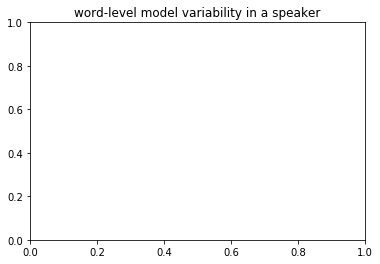

In [41]:
plt.title("word-level model variability in a speaker")
plt.hist(model_scores)

# SV Test

In [42]:
sv_model = si_model
sv_config = si_config

In [43]:
models = dict.fromkeys(pick_words+["command_random"])
for key in models.keys():
    model = si_config['model_class'](si_config)
    model.load("models/si_{}_model.pt".format(key))
    models[key] = model

NameError: name 'pick_words' is not defined

In [44]:
from scipy.spatial.distance import cosine
def spk_verify(spk_model, test_in, sent_label=None, who=False):
    best_score = -2
    pred_spk = 'Unknown'
    is_unknown = True
    
    for spk in spk_model.keys():
        if sent_label is not None:
            signature = spk_model[spk][sent_label]
            signature_uni = np.mean(spk_model[spk],0)
            score = max(1-cosine(test_in, signature), 1-cosine(test_in,signature_uni))
        else:
            signature_uni = spk_model[spk]
            score = 1-cosine(test_in, signature_uni)
            
        if score > best_score:
            best_score = score     
            pred_spk = spk
    if who:
        return pred_spk, best_score
    else:
        return best_score

In [45]:
from sklearn.metrics import roc_curve, auc
def roc_auc_eer(dists, labels):
    """
        dists: 1D-Array, [samples]
        labels: 1D-Array, [samples]
    """
    fpr, tpr, thres = roc_curve(labels, dists, pos_label=1)
    roc_auc = auc(fpr, tpr)
    fnr = 1 - tpr
    eer_ths = thres[np.nanargmin(np.absolute(fnr - fpr))]
    eer = fpr[np.nanargmin(np.absolute(fnr - fpr))]
    roc_bundle = {'fpr':fpr, 'tpr':tpr, 'thres':thres}
    np.save(open('roc_data.npy', 'wb'), roc_bundle)

    return roc_auc, eer, eer_ths

In [31]:
test_uttrs = sv_df[(sv_df.spk.isin(test_spks)) & (sv_df.sent.isin(main_sents))].sample(n=len(dev_uttrs))
print("number of dev uttrs: %d"%len(dev_uttrs))
print("number of test uttrs: %d"%len(test_uttrs))

NameError: name 'main_sents' is not defined

In [51]:
len(neg_utters)

205

In [48]:
import voxc_sv as vox
from voxc_sv.utils import spk_verify, roc_auc_eer
uni_pos_scores = []
uni_neg_scores = []
speaker_model = uni_spk_models

pos_utters = pd.concat([v for v in sv_test.values()])
neg_utters = unknown_test

for i, row in pos_utters.iterrows():
    audio_path = os.path.join(data_dir, row.sent, row.file)
    test_in = hk.embed(sv_config, sv_model, audio_path)
    score = spk_verify(uni_spk_models, test_in, None)
#     score = sv_models[row.spk](test_in, Variuni_spk_models[row.spk])
    uni_pos_scores.append(score)
    
for i, row in neg_utters.iterrows():
    audio_path = os.path.join(data_dir, row.sent, row.file)
    test_in = hk.embed(sv_config, sv_model, audio_path)
    score = spk_verify(uni_spk_models, test_in)
    uni_neg_scores.append(score)

dists = np.concatenate((uni_pos_scores, uni_neg_scores), 0)
labels = np.concatenate((np.ones_like(uni_pos_scores), np.zeros_like(uni_neg_scores)), 0)
auc_, eer_, uni_eer_ths = roc_auc_eer(dists, labels)
print("auc: {}, eer: {}".format(auc_, eer_))
uni_pos_scores = np.array(uni_pos_scores)
uni_neg_scores = np.array(uni_neg_scores)

auc: 0.9872030408615775, eer: 0.05853658536585366


(array([ 10.,  13.,  57.,  43.,  41.,  21.,   8.,   5.,   3.,   4.]),
 array([-0.07218479, -0.00790868,  0.05636743,  0.12064355,  0.18491966,
         0.24919577,  0.31347188,  0.377748  ,  0.44202411,  0.50630022,
         0.57057633]),
 <a list of 10 Patch objects>)

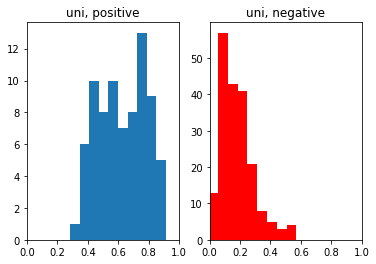

In [49]:
subplot(121)
plt.xlim([0, 1.0])
plt.title("uni, positive")
plt.hist(uni_pos_scores)
subplot(122)
plt.xlim([0, 1.0])
plt.title("uni, negative")
plt.hist(uni_neg_scores, color='r')

In [ ]:
word_pos_scores = []
word_neg_scores = []
speaker_model = uni_spk_models
for i, row in dev_uttrs.iterrows():
    audio_path = os.path.join(data_dir, row.sent, row.file)
    test_in = hk.embed(sv_config, sv_model, audio_path)
    word_label = sent_labels.index(row.sent)
    score = spk_verify(word_spk_models, test_in, word_label)
    word_pos_scores.append(score)
    
for i, row in test_uttrs.iterrows():
    audio_path = os.path.join(data_dir, row.sent, row.file)
    test_in = hk.embed(sv_config, sv_model, audio_path)
    word_label = sent_labels.index(row.sent)
    score = spk_verify(word_spk_models, test_in, word_label)
    word_neg_scores.append(score)

dists = np.concatenate((word_pos_scores, word_neg_scores), 0)
labels = np.concatenate((np.ones_like(word_pos_scores), np.zeros_like(word_neg_scores)), 0)
auc_, eer_, word_eer_ths = roc_auc_eer(dists, labels)
print("auc: {}, eer: {}".format(auc_, eer_))

In [ ]:
subplot(121)
plt.xlim([0, 1.0])
plt.title("word, positive")
plt.hist(word_pos_scores)
subplot(122)
plt.xlim([0, 1.0])
plt.title("word, negative") 
plt.hist(word_neg_scores, color='r')

In [ ]:
uni_fr_samples = dev_uttrs[(np.array(uni_pos_scores) < uni_eer_ths)]
uni_fa_samples = test_uttrs[(np.array(uni_neg_scores) > uni_eer_ths)]
uni_bad_samples = pd.concat([uni_fr_samples, uni_fa_samples])
print("uni_fr: %d, uni_fa: %d"%(len(uni_fr_samples), len(uni_fa_samples)))

In [ ]:
word_fr_samples = dev_uttrs[(np.array(word_pos_scores) < word_eer_ths)]
word_fa_samples = test_uttrs[(np.array(word_neg_scores) > word_eer_ths)]
word_bad_samples = pd.concat([word_fr_samples, word_fa_samples])
print("word_fr: %d, word_fa: %d"%(len(word_fr_samples), len(word_fa_samples)))

In [ ]:
# overlapped bad examles
overlap_bad_examples = word_bad_samples[word_bad_samples.index.isin(uni_bad_samples.index)]
print("shared bad examples: %d/%d"%(len(overlap_bad_examples), len(word_bad_samples)))

In [ ]:
test_scores = []
print("enrolled_spks:{}".format(enroll_spks))
for i, row in uni_bad_samples.iterrows():
    audio_path = os.path.join(data_dir, row.sent, row.file)
    test_in = hk.embed(sv_config, sv_model, audio_path)
    word_label = sent_labels.index(row.sent)
#     score = 1 - cosine(test_in, word_spk_models[row.spk][word_label])
    score = spk_verify(uni_spk_models, test_in, None)
    test_scores.append(score)
    print("{} : {:.2f}".format(row.spk, score))

### different ths for each word

In [ ]:
for keyword in main_sents:
    word_pos_sample = dev_uttrs[dev_uttrs.sent == keyword]
    word_neg_sample = test_uttrs[test_uttrs.sent == keyword]

    word_pos_scores = []
    word_neg_scores = []
    for i, row in word_pos_sample.iterrows():
        audio_path = os.path.join(data_dir, row.sent, row.file)
        test_in = hk.embed(sv_config, sv_model, audio_path)
        word_label = sent_labels.index(row.sent)
        score = spk_verify(word_spk_models, test_in, word_label)
        word_pos_scores.append(score)

    for i, row in word_neg_sample.iterrows():
        audio_path = os.path.join(data_dir, row.sent, row.file)
        test_in = hk.embed(sv_config, sv_model, audio_path)
        word_label = sent_labels.index(row.sent)
        score = spk_verify(word_spk_models, test_in, word_label)
        word_neg_scores.append(score)

    dists = np.concatenate((word_pos_scores, word_neg_scores), 0)
    labels = np.concatenate((np.ones_like(word_pos_scores), np.zeros_like(word_neg_scores)), 0)
    auc_, eer_, _ = roc_auc_eer(dists, labels)
    print("{}: auc: {:.2f}, eer: {:.2f}".format(keyword, auc_, eer_))